**Author:** Beatrice Occhiena s314971. See [`LICENSE`](https://github.com/beatrice-occhiena/Computational_intelligence/blob/main/LICENSE) for details.
- institutional email: `S314971@studenti.polito.it`
- personal email: `beatrice.occhiena@live.it`
- github repository: [https://github.com/beatrice-occhiena/Computational_intelligence.git](https://github.com/beatrice-occhiena/Computational_intelligence.git)

**Resources:** These notes are the result of additional research and analysis of the lecture material presented by Professor Giovanni Squillero for the Computational Intelligence course during the academic year 2023-2024 @ Politecnico di Torino. They are intended to be my attempt to make a personal contribution and to rework the topics covered in the following resources.
- [https://github.com/squillero/computational-intelligence](https://github.com/squillero/computational-intelligence)
- Stuart Russel, Peter Norvig, *Artificial Intelligence: A Modern Approach* [3th edition]

# LAB 01 - Set Covering

## Introduction
---

### Problem Statement
The Set Covering Problem is a classical optimization problem in computer science and mathematics. It can be stated as follows:

> Given a set of elements $U = \{1, 2, ..., n\}$, and a collection $S_1, S_2, ..., S_m$ of subsets of $U$ such that $\bigcup_{i=1}^m S_i = U$, find the smallest sub-collection of $S_i$ whose union equals $U$. 

INPUT
- A finite universe $U$ of n elements
- A collection of subsets $S_i$ of $U$

OUTPUT: A sub-collection of $S_i$ whose union equals $U$

OBJECTIVE: Minimize the number of sets in the sub-collection

### Project Objectives

**1 - Implementation of Search Algorithms**

The aim of this project is to implement a set of search algorithms to efficiently solve the Set Covering Problem. We are going to explore the differences between the following algorithms in terms of performance and quality of the solution.

**2 - Integration of Heuristic Function (H)**

Focusing on the A* search algorithm, we will employ a heuristic function (H) to guide the search process. The heuristic function estimates the distance from the current state to the goal state. 
To be sure to find the optimal solution, the heuristic function must be:
- Admissible: It never overestimates the cost of reaching the goal, so that $H(n) \leq H^*(n)$
- Consistent: It satisfies the triangle inequality, so that $H(n) \leq c(n, a, n') + H(n')$

In this project, we will explore different heuristics for the Set Covering Problem and compare their performances in terms of:
- Number of nodes expanded
- Number of nodes generated
- Quality of the solution


**3 - Special Sets Consideration**

In practice, some subsets might have unique characteristics or properties. We will investigate how to handle "special sets" within the context of the Set Covering Problem to improve the efficiency of the search.

**4 - Optimizing Set Order**

The order in which sets are selected can impact the efficiency of the solution. We will analyze strategies for optimizing the order in which subsets are considered to achieve more efficient and quicker solutions.


## Code Implementation
---

### Imported libraries

In [1]:
import numpy as np
import queue
from collections import namedtuple
import matplotlib.pyplot as plt


### Problem instance
First of all, we need to define the `UNIVERSE_SIZE` and the `NUMBER_OF_SETS`. Each set is represented by a vector of binary values, where 1 means that the element is present in the set, 0 means that the element is not present in the set. We can control the `DENSITY` of the sets by adjusting the probability of 1s in the vector.

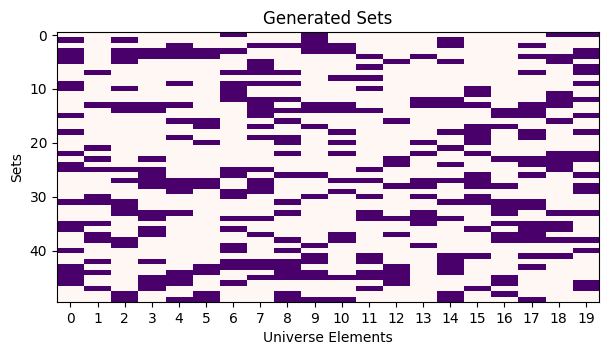

In [2]:
UNIVERSE_SIZE = 20
NUMBER_OF_SETS = 50
DENSITY = 0.3

"""
  SETS GENERATION
  Boolean array of shape (NUMBER_OF_SETS, UNIVERSE_SIZE) 
  where sets[i, j] is True if the j-th element of the universe is in the i-th set.
"""
sets = np.random.rand(NUMBER_OF_SETS, UNIVERSE_SIZE) < DENSITY

"""
  SETS VISUALIZATION
  Each set is represented by a row of the matrix.
  The elements of the universe are represented by the columns of the matrix.
"""
plt.figure(figsize=(7, 3.5))
plt.imshow(sets, cmap='RdPu', aspect='auto')
plt.title("Generated Sets")
plt.xlabel("Universe Elements")
plt.xticks(np.arange(UNIVERSE_SIZE))
plt.ylabel("Sets")
plt.show()

"""
  PROBLEM FEASIBILITY CHECK
  Check if the sets cover the universe
  i.e. if the sum of the sets is greater than 0 for all elements of the universe.
"""
assert np.all(np.sum(sets, axis=0) > 0)


### State Representation

To conveniently represent the state of the problem, we will use a `namedtuple` object of 2 elements:
- `taken`: a list of the sets that have been selected so far
- `not_taken`: a list of the sets that are still available

In Python, the namedtuple is a factory function for creating simple, immutable objects that are similar to tuples. It's a convenient way to define lightweight classes for storing and accessing data, typically used for creating simple data structures where we don't need to add methods or complex behaviors.

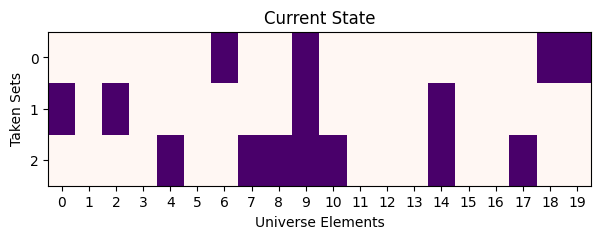

In [3]:
State = namedtuple("State",["taken","not_taken"])
initial_state = State(set(), set(range(NUMBER_OF_SETS)))

"""
  STATE VISUALIZATION
  Each state is represented by a pair of sets.
  The first set contains the indices of the sets that are taken.
  The second set contains the indices of the sets that are not taken.
"""
def visualize_state(state, is_goal=False):
  taken_sets = state.taken

  plt.figure(figsize=(7, 2))
  plt.imshow(sets[list(taken_sets), :], cmap='RdPu', aspect='auto')
  plt.title("Current State" if not is_goal else "Goal State")
  plt.xlabel("Universe Elements")
  plt.xticks(np.arange(UNIVERSE_SIZE))
  plt.ylabel("Taken Sets")
  # on the ticks of the y axis, show the indices of the taken sets
  plt.yticks(np.arange(len(taken_sets)), list(taken_sets))
  plt.show()

# example of state visualization
visualize_state(State(taken={0,1,2}, not_taken={3,4,5}))

### Problem Initialization
In [Search_Problems_Classes.py](../Lab_01/Search_Problems_Classes.py) I've defined three classes:
1. `Class Node`: that represents a node of the search tree or graph
2. `Class SearchProblem`: that represents the problem to be solved and a series of methods to manage its states, actions, heuristic function, etc.
3. `Class SearchStrategy`: that represents the search strategy to be used to solve the problem and a series of methods to manage the search process and the performance evaluation.

##### 🤚🏻 Action definition 
Since we are using a state representation that keeps track of the sets that have been selected and the sets that are still available, the action definition is straightforward: each time we select a set, we remove it from the `not_taken` list and add it to the `taken` list.
- step_cost = 1

##### 🎯 Goal test
The goal state is reached when the union of the sets in the `taken` list equals the universe. We can check this condition by converting the `taken` list into a binary vector and checking if the sum of the vector equals the `UNIVERSE_SIZE`.

##### 🧭 Heuristic function
The heuristic function estimates the distance from the current state to the goal state. In this case, we will use the number of elements that are still missing from the universe. We can compute this value by converting the `taken` list into a binary vector and checking how many 0s are in the vector.

In [4]:
from Search_Problems_Classes import SearchProblem

class SetCovering(SearchProblem):

  def is_goal(self, state):
    return np.sum(np.sum(sets[list(state.taken)], axis=0) > 0) == UNIVERSE_SIZE
  
  def actions(self, state):
    return list(state.not_taken)
  
  def apply_action(self, state, action):
    return State(state.taken | {action}, state.not_taken - {action})
  
  def h(self, node):
    return UNIVERSE_SIZE - np.sum(np.sum(sets[list(node.state.taken)], axis=0) > 0)

problem = SetCovering(initial_state)

### Search Strategies
Now we can define the search strategies that we intend to use to solve the problem. Note that the search strategy is independent of the problem, so we can test and compare different search strategies on our set covering problem.

In [17]:
from Search_Problems_Classes import SearchStrategy

type = 'tree_search'

# UNINFORMED SEARCH STRATEGIES
bfs = SearchStrategy(type,'breadth_first')
dfs = SearchStrategy(type,'depth_first')
ucs = SearchStrategy(type,'uniform_cost')
dls = SearchStrategy(type,'depth_limited', 5)
ids = SearchStrategy(type,'iterative_deepening')
bds = SearchStrategy(type,'bidirectional')

# INFORMED SEARCH STRATEGIES
greedy = SearchStrategy(type,'greedy_best_first')
astar = SearchStrategy(type,'a_star')

#### 🙈 Uninformed Search Strategies
These strategies do not use any additional information about the problem to guide the search process. They are called "blind" search strategies because they do not have any clue about where the goal state is located nor how far it is from the current state.

$\implies$ no problem-specific knowledge to guide the search process

##### Breadth-First Search

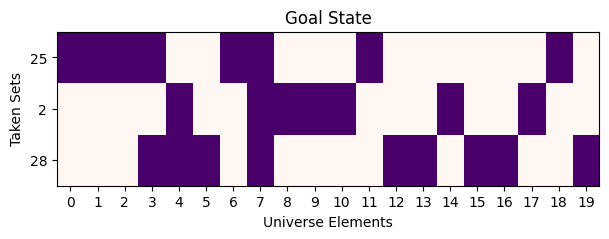

Search type: tree_search
Strategy: breadth_first
----------------------
Solution found:
Path: [2, 25, 28]
Path cost: 3
Number of steps: 8383
Max frontier size: 388172


In [18]:
sol = bfs.search(problem)
visualize_state(sol.state, True)
bfs.print_solution(problem, sol)

##### Depth-First Search

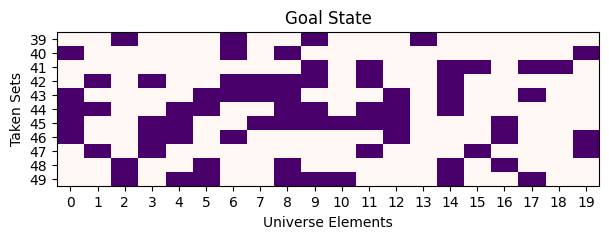

Search type: tree_search
Strategy: depth_first
----------------------
Solution found:
Path: [49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39]
Path cost: 11
Number of steps: 11
Max frontier size: 445


In [7]:
sol = dfs.search(problem)
visualize_state(sol.state, True)
dfs.print_solution(problem, sol)


##### Uniform-Cost Search

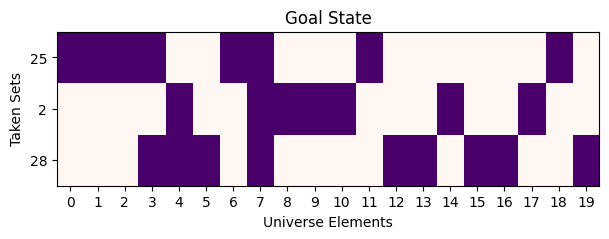

Search type: tree_search
Strategy: uniform_cost
----------------------
Solution found:
Path: [25, 28, 2]
Path cost: 3
Number of steps: 6948
Max frontier size: 322115


In [11]:
sol = ucs.search(problem)
visualize_state(sol.state, True)
ucs.print_solution(problem, sol)

##### Depth-Limited Search

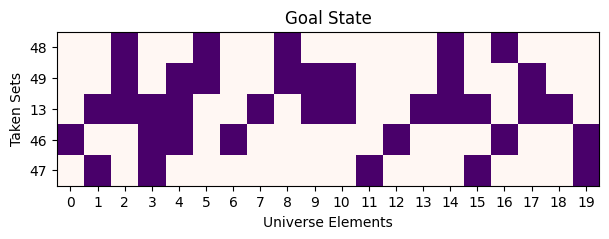

Search type: tree_search
Strategy: depth_limited
Limit: 5
----------------------
Solution found:
Path: [49, 48, 47, 46, 13]
Path cost: 5
Number of steps: 5
Max frontier size: 190


In [19]:
sol = dls.search(problem)
if sol is not None:
  visualize_state(sol.state, True)
dls.print_solution(problem, sol)

##### Iterative Deepening Search

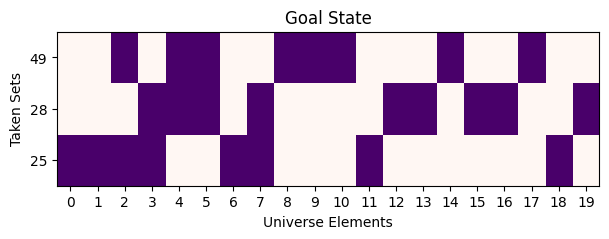

Search type: tree_search
Strategy: iterative_deepening
----------------------
Solution found:
Path: [49, 28, 25]
Path cost: 3
Number of steps: 75
Max frontier size: 97


In [20]:
sol = ids.search(problem)
visualize_state(sol.state, True)
ids.print_solution(problem, sol)

##### Bidirectional Search

In this case, bidirectional search is not easily applicable because we don't have any information about one specific goal state. We are looking for a set of states that satisfy a certain condition (the union of the sets in the `taken` list equals the universe). 😢..

This strategy is more suitable when we have only one specific goal state to reach.

#### 🗺️ Informed Search Strategies

##### Greedy Best-First Search

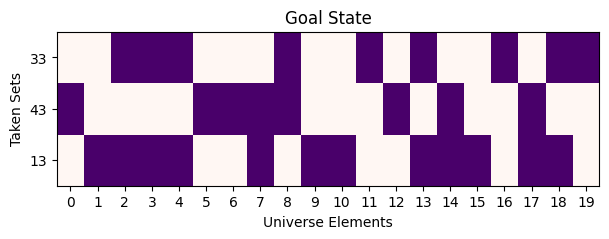

Search type: tree_search
Strategy: greedy_best_first
----------------------
Solution found:
Path: [13, 43, 33]
Path cost: 3
Number of steps: 3
Max frontier size: 97


In [24]:
sol = greedy.search(problem)
visualize_state(sol.state, True)
greedy.print_solution(problem, sol)

##### A* Search

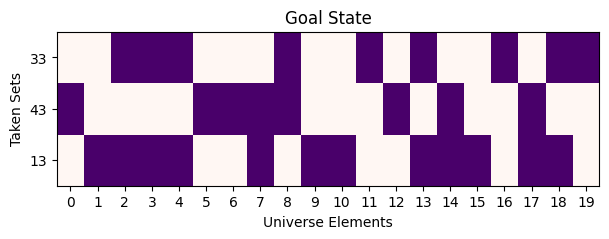

Search type: tree_search
Strategy: a_star
----------------------
Solution found:
Path: [13, 43, 33]
Path cost: 3
Number of steps: 3
Max frontier size: 97


In [30]:
sol = astar.search(problem)
visualize_state(sol.state, True) # visualize the solution
astar.print_solution(problem, sol) # print information about the solution

## Final Considerations
---

### Heuristic Function

In the Set Covering Problem (SCP), finding an admissible heuristic that can be used with informed search algorithms like A* can be challenging. The SCP is a well-known NP-hard problem, which means that it is computationally difficult to find an optimal solution in polynomial time.

Our approach is therefore to use heuristics that are not guaranteed to be admissible but provide good estimates of the cost to reach the goal.

- 📈 Heuristic 1: Number of elements still missing from the universe

- 📈 Heuristic 2: Ratio between the number of elements still missing from the universe and the number of sets still available (less effective)

I also tried to use a heuristic that tries to penalize the sets in which the elements are more concentrated, but it didn't work very well.

### Special Sets

I've identified two types of special sets that can be used to improve the efficiency of the search process:
- **Critical sets**: sets that contain elements that are not present in any other set
- **Redundant sets**: sets that contain elements that are already present in other sets

To improve the efficiency of the search process, we can consider the critical sets first and the redundant sets last. This can be done by `sorting` the sets in descending order of the number of elements that are not present in any other set.

In [ ]:
def is_critical_set(index):
  return np.sum(sets[index], axis=0) == 1

### Order of the sets
Our assumption: *The order in which we select the sets can significantly impact the efficiency of the solution.*

We saw how the most computationally intensive search strategy is the Breadth-First Search, that explores all the nodes at a certain depth before moving to the next depth level. Since it is highly improbable that the first set we select is the one that covers the entire universe, we will need to explore all the nodes at the first depth level before moving to the next depth level. And so on for the next shallow-depth levels.

To improve the efficiency of the search, we can try to select the sets that cover the largest number of elements first. In this way, we will be able to cover a larger portion of the universe with fewer sets, and we will be able to reach the goal state a little faster. Of course, since BFS is always optimal, the path cost will be the same, but we will be able to reach the goal state in fewer steps.

🥫🥫🥫🥫...🥫🥫🥫....🥫🥫..🥫🥫..🥫

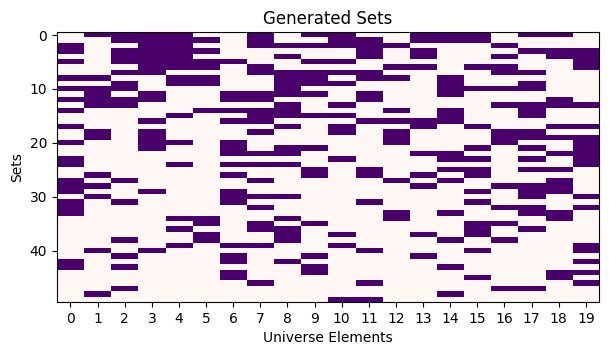

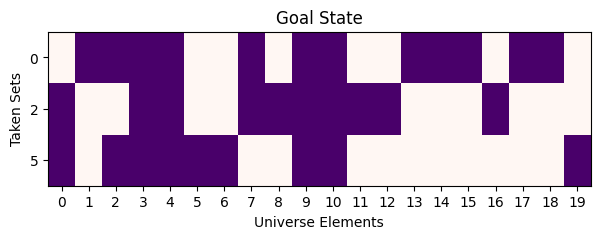

Search type: tree_search
Strategy: breadth_first
----------------------
Solution found:
Path: [0, 2, 5]
Path cost: 3
Number of steps: 2552
Max frontier size: 119997


In [42]:
# order the sets' matrix by their number of elements (descending order)
ordered_sets = sets[np.argsort(np.sum(sets, axis=1))[::-1]]

"""
  ORDERED SETS VISUALIZATION
  Each set is represented by a row of the matrix.
  The elements of the universe are represented by the columns of the matrix.
"""
plt.figure(figsize=(7, 3.5))
plt.imshow(ordered_sets, cmap='RdPu', aspect='auto')
plt.title("Generated Sets")
plt.xlabel("Universe Elements")
plt.xticks(np.arange(UNIVERSE_SIZE))
plt.ylabel("Sets")
plt.show()

def visualize_state_ordered(state, is_goal=False):
  taken_sets = state.taken

  plt.figure(figsize=(7, 2))
  plt.imshow(ordered_sets[list(taken_sets), :], cmap='RdPu', aspect='auto')
  plt.title("Current State" if not is_goal else "Goal State")
  plt.xlabel("Universe Elements")
  plt.xticks(np.arange(UNIVERSE_SIZE))
  plt.ylabel("Taken Sets")
  # on the ticks of the y axis, show the indices of the taken sets
  plt.yticks(np.arange(len(taken_sets)), list(taken_sets))
  plt.show()

State = namedtuple("State",["taken","not_taken"])
initial_state = State(list(), list(range(NUMBER_OF_SETS)))

class SetCovering_Ordered(SetCovering):

  def is_goal(self, state):
    return np.sum(np.sum(ordered_sets[list(state.taken)], axis=0) > 0) == UNIVERSE_SIZE
  
  def actions(self, state):
    return list(state.not_taken)
  
  def apply_action(self, state, action):
    return State(state.taken + [action], state.not_taken[:action] + state.not_taken[action+1:])

  def h(self, node):
    return UNIVERSE_SIZE - np.sum(np.sum(ordered_sets[list(node.state.taken)], axis=0) > 0)

problem_ordered = SetCovering_Ordered(initial_state)

sol = bfs.search(problem_ordered)
visualize_state_ordered(sol.state, True)
bfs.print_solution(problem_ordered, sol)

We can compare this new data with the performances of the original BFS performed on non-ordered sets.
- Path: [2, 25, 28]
- Path cost: 3
- Number of steps: `8383` ⚠️
- Max frontier size: `388172` ⚠️

The difference is not huge, but it is significant. We can see that the number of steps is reduced by 1/3, and the max frontier size is reduced by 1/4. This is a good result, considering that we didn't change the search strategy, we just changed the order in which we select the sets.

Notice that for the Depth-First Search, this ordering strategy is counterproductive. Since the DFS explores the nodes at the deepest level first, we will end up selecting the sets that cover the smallest number of elements first. This means that we will need to explore all the nodes at the deepest level before moving to the next level.

$\implies$ The optimal order in this case is the opposite of the optimal order for the BFS.

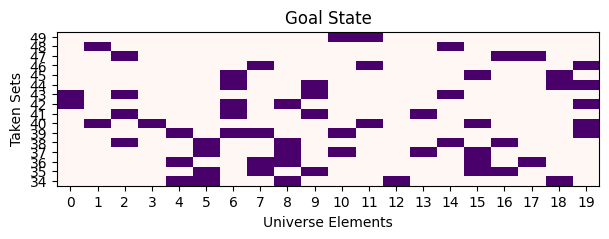

Search type: tree_search
Strategy: depth_first
----------------------
Solution found:
Path: [49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34]
Path cost: 16
Number of steps: 16
Max frontier size: 630


In [43]:
# order the sets' matrix by their number of elements (descending order)
ordered_sets = sets[np.argsort(np.sum(sets, axis=1))[::-1]]

sol = dfs.search(problem_ordered)
visualize_state_ordered(sol.state, True)
dfs.print_solution(problem_ordered, sol)

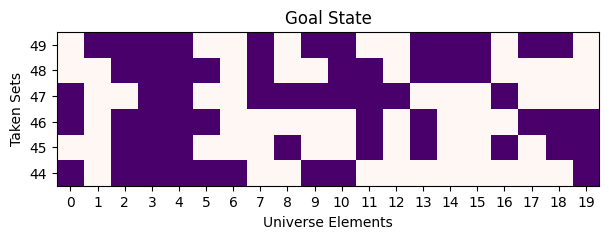

Search type: tree_search
Strategy: depth_first
----------------------
Solution found:
Path: [49, 48, 47, 46, 45, 44]
Path cost: 6
Number of steps: 6
Max frontier size: 235


In [45]:
# order the sets' matrix by their number of elements (ascending order)
ordered_sets = sets[np.argsort(np.sum(sets, axis=1))]

sol = dfs.search(problem_ordered)
visualize_state_ordered(sol.state, True)
dfs.print_solution(problem_ordered, sol)

Compare the results with the original DFS performed on non-ordered sets.
- Path: [49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39]
- Path cost: `11`
- Number of steps: `11`
- Max frontier size: `445`

The A* search performances are not affected by the order of the sets. This is because the A* search is guided by the heuristic function, so it doesn't need to explore all the nodes at a certain depth level before moving to the next level. It can move to the next level as soon as it finds a node that has a lower heuristic value than the nodes at the current level.

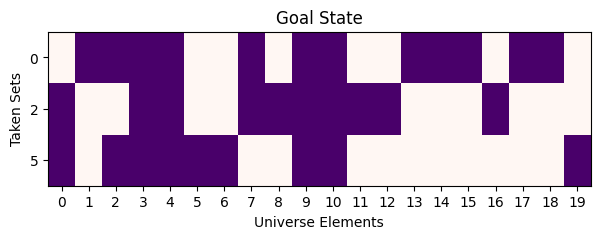

Search type: tree_search
Strategy: a_star
----------------------
Solution found:
Path: [0, 2, 5]
Path cost: 3
Number of steps: 3
Max frontier size: 97


In [44]:
sol = astar.search(problem_ordered)
visualize_state_ordered(sol.state, True)
astar.print_solution(problem_ordered, sol)